In [153]:
import math
import urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [154]:
train = pd.read_csv('/kaggle/input/income/train.csv')
test = pd.read_csv('/kaggle/input/income/test.csv')
train.rename(columns={'income_>50K':'income'}, inplace=True)
train

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43952,52,Private,68982,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1
43953,19,Private,116562,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,0
43954,30,Private,197947,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,58,United-States,0
43955,46,Private,97883,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,35,United-States,0


In [155]:
TARGET = 'income'
CATEGORICAL_FEATURES = ['education', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
NUMERICAL_FEATURES = [col for col in train.columns if col not in CATEGORICAL_FEATURES + [TARGET]]

In [156]:
def prepare_dataframe(dataframe):
    # Cast the categorical features to string.
    for feature_name in CATEGORICAL_FEATURES:
        dataframe[feature_name] = dataframe[feature_name].astype(str)


prepare_dataframe(train)
prepare_dataframe(test)
test.head().T

,0,1,2,3,4
age,39,32,47,19,46
workclass,Self-emp-not-inc,Private,Private,Private,Self-emp-not-inc
fnlwgt,327120,123253,232628,374262,311231
education,HS-grad,Assoc-acdm,HS-grad,12th,HS-grad
educational-num,9,12,9,8,9
marital-status,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Never-married,Married-civ-spouse
occupation,Craft-repair,Craft-repair,Craft-repair,Handlers-cleaners,Farming-fishing
relationship,Husband,Husband,Husband,Own-child,Husband
race,White,White,Black,White,White
gender,Male,Male,Male,Male,Male


In [157]:
train_losses = []
val_losses = []

def run_experiment(model, train_data, val_data, num_epochs=1, batch_size=None):

    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label=TARGET
    )
    val_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        val_data, label=TARGET
    )

    for epoch in range(num_epochs):
        history = model.fit(train_dataset, epochs=1, batch_size=batch_size, verbose=0)
        
        # Track training loss
        train_loss = history.history['loss'][0]
        train_losses.append(train_loss)
        
        # Evaluate model on validation dataset to compute validation loss
        val_loss = model.evaluate(val_dataset, verbose=0)[0]
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss}, Val Loss: {val_loss}")
    
    _, accuracy = model.evaluate(val_dataset, verbose=0)
    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

In [158]:
def specify_feature_usages():
    feature_usages = []

    for feature_name in NUMERICAL_FEATURES:
        feature_usage = tfdf.keras.FeatureUsage(
            name=feature_name, semantic=tfdf.keras.FeatureSemantic.NUMERICAL
        )
        feature_usages.append(feature_usage)

    for feature_name in CATEGORICAL_FEATURES:
        feature_usage = tfdf.keras.FeatureUsage(
            name=feature_name, semantic=tfdf.keras.FeatureSemantic.CATEGORICAL
        )
        feature_usages.append(feature_usage)

    return feature_usages

In [159]:
def create_model_inputs():
    inputs = {}

    for feature_name in NUMERICAL_FEATURES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(), dtype=tf.float32
        )

    for feature_name in CATEGORICAL_FEATURES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(), dtype=tf.string
        )

    return inputs

In [160]:
class ExpandDimsLayer(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

In [161]:
def create_embedding_encoder(size=None):
    inputs = create_model_inputs()
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURES:
            # Get the vocabulary of the categorical feature.
            vocabulary = sorted(
                [str(value) for value in list(train[feature_name].unique())]
            )
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = lookup(inputs[feature_name])
            # Create an embedding layer with the specified dimensions
            vocabulary_size = len(vocabulary)
            embedding_size = int(math.sqrt(vocabulary_size))
            feature_encoder = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_size
            )
            # Convert the index values to embedding representations.
            encoded_feature = feature_encoder(value_index)
        else:
            # Expand the dimensions of the numerical input feature and use it as-is.
            # Wrap the expand_dims operation in the custom layer
            expand_dims_layer = ExpandDimsLayer()
            encoded_feature = expand_dims_layer(inputs[feature_name])
        # Add the encoded feature to the list.
        encoded_features.append(encoded_feature)
    # Concatenate all the encoded features.
    encoded_features = layers.concatenate(encoded_features, axis=1)
    # Apply dropout.
    encoded_features = layers.Dropout(rate=0.25)(encoded_features)
    # Perform non-linearity projection.
    encoded_features = layers.Dense(
        units=size if size else encoded_features.shape[-1], activation="gelu"
    )(encoded_features)
    # Create and return a Keras model with encoded features as outputs.
    return keras.Model(inputs=inputs, outputs=encoded_features)

In [162]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

Epoch 1/25 - Train Loss: 654.7279663085938, Val Loss: 231.5320587158203
Epoch 2/25 - Train Loss: 144.06280517578125, Val Loss: 37.65951156616211
Epoch 3/25 - Train Loss: 111.76329803466797, Val Loss: 20.738483428955078
Epoch 4/25 - Train Loss: 102.1523208618164, Val Loss: 103.6413803100586
Epoch 5/25 - Train Loss: 96.54413604736328, Val Loss: 70.48294830322266
Epoch 6/25 - Train Loss: 86.7591781616211, Val Loss: 43.60966110229492
Epoch 7/25 - Train Loss: 44.28001022338867, Val Loss: 61.47249221801758
Epoch 8/25 - Train Loss: 39.86094665527344, Val Loss: 30.103593826293945
Epoch 9/25 - Train Loss: 49.06674575805664, Val Loss: 56.00343704223633
Epoch 10/25 - Train Loss: 30.420650482177734, Val Loss: 14.156854629516602
Epoch 11/25 - Train Loss: 70.07377624511719, Val Loss: 16.30267906188965
Epoch 12/25 - Train Loss: 47.15970230102539, Val Loss: 59.0467529296875
Epoch 13/25 - Train Loss: 53.72221755981445, Val Loss: 135.94671630859375
Epoch 14/25 - Train Loss: 73.4688491821289, Val Loss: 2

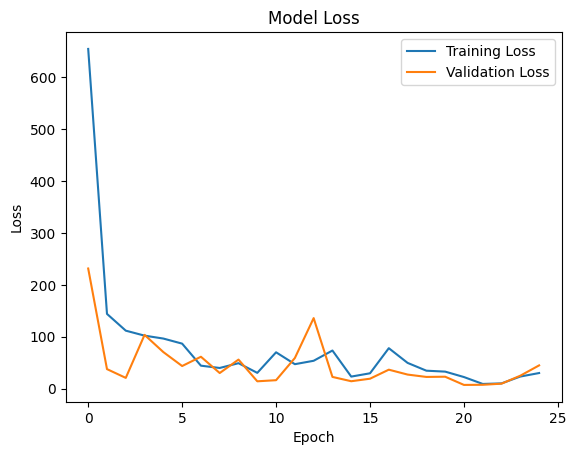

In [167]:
def create_nn_model(encoder, learning_rate=0.001):
    inputs = create_model_inputs()
    embeddings = encoder(inputs)
    output = layers.Dense(units=1, activation="sigmoid")(embeddings)

    nn_model = keras.Model(inputs=inputs, outputs=output)
    nn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy("accuracy")],
    )
    return nn_model


embedding_encoder = create_embedding_encoder(size=64)

run_experiment(
    create_nn_model(embedding_encoder),
    train_data,
    val_data,
    num_epochs=25,
    batch_size=256,
)

# Plot the training and validation losses over epochs
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()